# Perceptron & Multi-Layer Perceptron (MLP): Nonlinear Data


In this notebook we will study the performance of the Perceptron model on a non-linear data set in comparison to another linear model, i.e., Logistic Regression. Then, we will study the performance of the Multi-Layer Perceptron (MLP), which is a non-linear model.

Since both Perceptron and Logistic Regression are **linear models**, they are unable to classsify non-linear data. We will see that these models won't create non-linear decision boundary.

One approach to classify non-linear data by using these linear models is to map the features onto a high-dimensional space such that data becomes linearly separable.

However, this solution suffers from the **curse of dimensionality** when the dataset is high-dimensional (e.g., image classfication problems in which number of features are very large). Also, it is not clear how to optimaly choose the basis function. Thus, feature augmentation is not a feasible solution for high-dimensional non-linear data.

We have seen that using the **kernel trick** we can bypass the curse of dimensionality. The Gaussian Radial Basis Function (RBF) kernel based Support Vector Machine (SVM) classifier can create non-linear decision boundary without exploding the feature dimension. However, the dual optimization problem that we use to derive optimal solution for the kernel SVM is infeasible for large data set (it's complexity is $O(N^2d)$ ~ $O(N^3d)$).

### Very Large and Non-Linear Dataset

Thus, for a very large and non-linear data set, we need a model that does the classification without exploding the feature space as much the SVM models do.

To achieve this goal, we use **non-linear** models. 

The Multi-Layer Perceptron (MLP) or Artificial Neural Network (ANN) is a non-linear model that is able to create non-linear decision boundary.

In this notebook we will see how to classify a non-linear dataset using the MLP. But before that we will attempt to classify the data using Perceptron and Logistic Regression. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_circles

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Function for Drawing Decision Boundary

We use two functions for plotting the decision boundary:
- Equation based
- Class probability based

Detail discussion on these two functions are given in the "Logistic Regression - Binary Classification" notebook.

In [2]:
def decision_boundary_equation_based(clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    
    w = clf.coef_[0]
    b = clf.intercept_[0]

    x1 = np.linspace(xmin, xmax, 100)
    decision_boundary = -(b + w[0]*x1)/w[1]
    plt.plot(x1, decision_boundary, "k--", linewidth=3)
    
    
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()
    

# Dataset

We will use Scikit-Learn's "datasets.make_circles" function to generate a synthetic non-linear dataset that is suitable for investigating classification (as well as clustering) models. It creates a large circle containing a smaller circle in 2D.

The following two parameters are used by the make_circles function:

- factor : Scale factor between inner and outer circle. Range 0 ~ 1.

- noise : Standard deviation of Gaussian noise added to the data.

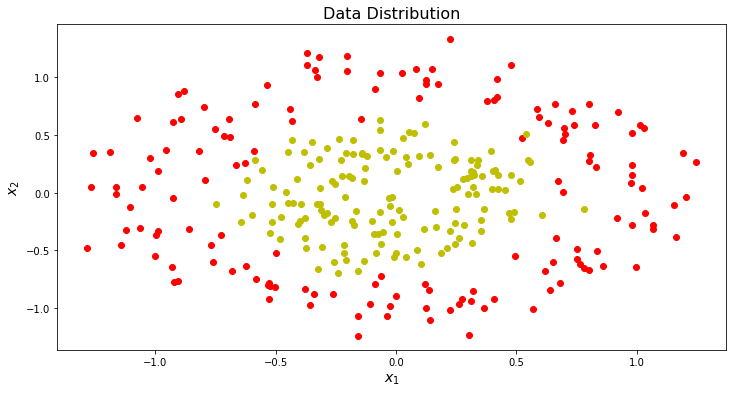

In [3]:
X, y = make_circles(300, factor=0.4, noise=0.15, random_state=0)

plt.figure(figsize=(12, 6))
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.title("Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
#plt.xticks(())
#plt.yticks(())
plt.show()

## Split Data Into Training and Test Sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Standardize the Data

It is useful to standardize the data before applying Gradient Descent based approaches.

Also note that Multi-layer Perceptron is sensitive to feature scaling. So it is highly recommended to scale the data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that we must apply the same scaling to the test set for meaningful results.

In [5]:
scaler = StandardScaler()  

# fit only on the training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

# apply same transformation to test data
X_test = scaler.transform(X_test)  

## Logistic Regression

In [6]:
%%time
param_grid = {'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], 
              'tol': [1e-3, 1e-4], 'max_iter':[500, 1000],'C': [1, 10, 50]}

lg_reg = LogisticRegression()

lg_reg_cv = GridSearchCV(lg_reg, param_grid, scoring='accuracy', cv=5)
lg_reg_cv.fit(X_train, y_train)

params_optimal = lg_reg_cv.best_params_

print("Best Score (accuracy): %f" % lg_reg_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Best Score (accuracy): 0.608333
Optimal Hyperparameter Values:  {'C': 1, 'max_iter': 500, 'solver': 'liblinear', 'tol': 0.001}


CPU times: user 546 ms, sys: 3.07 ms, total: 549 ms
Wall time: 547 ms


/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [7]:
lg_reg_clf = LogisticRegression(**params_optimal)

lg_reg_clf.fit(X_train, y_train)

print("No. of Iterations:", lg_reg_clf.n_iter_ )
print("\nWeight Intercept:", lg_reg_clf.intercept_ )
print("Weight Coefficients:", lg_reg_clf.coef_ )


y_train_predicted = lg_reg_clf.predict(X_train)
#print(y_test_predict)

train_accuracy_logreg = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_logreg)

No. of Iterations: [2]

Weight Intercept: [0.11535974]
Weight Coefficients: [[-0.10058453 -0.08704143]]

Training Accuracy:  0.6791666666666667


## Logistic Regression: Evaluation on Test Data

In [8]:
y_test_predicted = lg_reg_clf.predict(X_test)

test_accuracy_logreg = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_logreg)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.5833333333333334

Test Confusion Matrix:
[[12 25]
 [ 0 23]]

Test Precision = 0.479167
Test Recall = 1.000000
Test F1 Score = 0.647887

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.32      0.49        37
           1       0.48      1.00      0.65        23

    accuracy                           0.58        60
   macro avg       0.74      0.66      0.57        60
weighted avg       0.80      0.58      0.55        60



## Perceptron

The relevant hyperparameters for the sklearn Perceptron model are.

- penalty : None, ‘l2’ or ‘l1’ or ‘elasticnet’

        The penalty (aka regularization term) to be used. Defaults to None.

- alpha : float

        Constant that multiplies the regularization term if regularization is used. Defaults to 0.0001

- tol : The stopping criterion. Defaults to 1e-3.

- max_iter : The maximum number of passes over the training data (aka epochs). 


We can vary these two hyperparameter (use grid search). 

In [9]:
%%time
param_grid = {'tol': [1e-3, 1e-4, 1e-5, 1e-6], 'max_iter':[500, 1000, 5000], 
              'penalty':['l2', 'l1', 'none'], 'alpha': [0.01, 0.1, 0.5]}

clf_perceptron = Perceptron()

clf_perceptron_cv = GridSearchCV(clf_perceptron, param_grid, scoring='accuracy', cv=5)
clf_perceptron_cv.fit(X_train, y_train)

params_optimal_perceptron = clf_perceptron_cv.best_params_

print("Best Score (accuracy): %f" % clf_perceptron_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_perceptron)
print("\n")

Best Score (accuracy): 0.537500
Optimal Hyperparameter Values:  {'alpha': 0.1, 'max_iter': 500, 'penalty': 'l2', 'tol': 0.001}


CPU times: user 644 ms, sys: 4.16 ms, total: 648 ms
Wall time: 647 ms


/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [10]:
perceptron_clf = Perceptron(tol=1e-6, max_iter=1000)
#perceptron_clf = Perceptron(**params_optimal_perceptron)

perceptron_clf.fit(X_train, y_train)

print("No. of Iterations:", perceptron_clf.n_iter_ )
print("\nWeight Intercept:", perceptron_clf.intercept_ )
print("Weight Coefficients:", perceptron_clf.coef_ )


y_train_predicted = perceptron_clf.predict(X_train)
#print(y_test_predict)

train_accuracy_perceptron = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_perceptron)

No. of Iterations: 7

Weight Intercept: [2.]
Weight Coefficients: [[ 0.99888353 -1.3201785 ]]

Training Accuracy:  0.6541666666666667


## Perceptron: Evaluation on Test Data

In [11]:
y_test_predicted = perceptron_clf.predict(X_test)

test_accuracy_perceptron = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_perceptron)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.5

Test Confusion Matrix:
[[ 7 30]
 [ 0 23]]

Test Precision = 0.433962
Test Recall = 1.000000
Test F1 Score = 0.605263

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.19      0.32        37
           1       0.43      1.00      0.61        23

    accuracy                           0.50        60
   macro avg       0.72      0.59      0.46        60
weighted avg       0.78      0.50      0.43        60



## Decision Boundary I: Equation Based

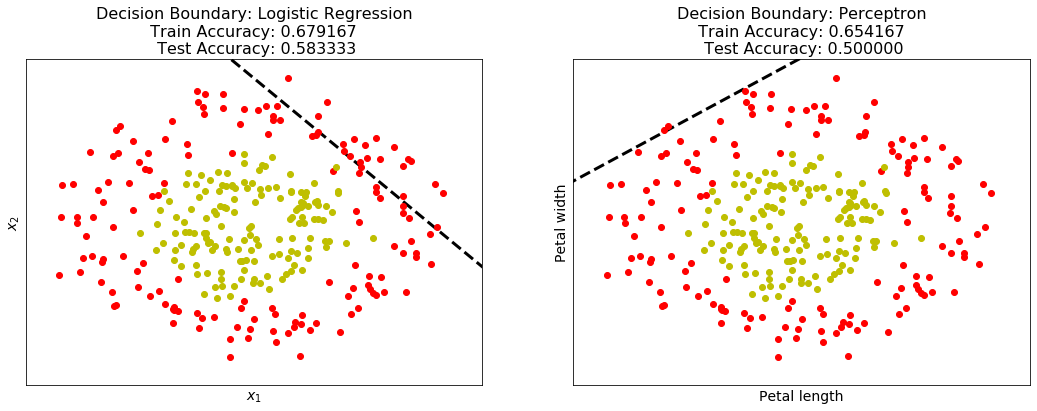

In [12]:
plt.figure(figsize=(18,6))

plt.subplot(121)
decision_boundary_equation_based(lg_reg_clf, X)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: Logistic Regression\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_logreg, test_accuracy_logreg) , fontsize=16)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_equation_based(perceptron_clf, X)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("Decision Boundary: Perceptron\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_perceptron, test_accuracy_perceptron) , fontsize=16)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.xticks(())
plt.yticks(())

plt.show()

## Decision Boundary II: Class Probability Based

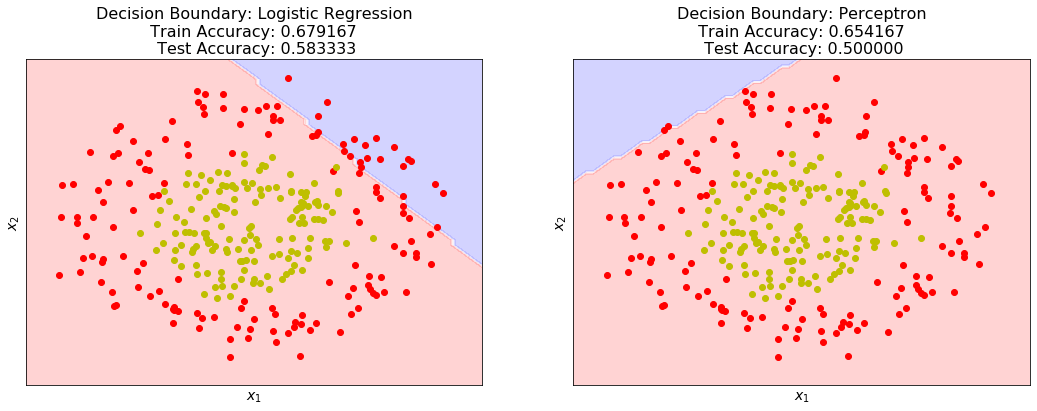

In [13]:
plt.figure(figsize=(18,6))

plt.subplot(121)
decision_boundary_class_colored(lg_reg_clf, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: Logistic Regression\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_logreg, test_accuracy_logreg) , fontsize=16)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_class_colored(perceptron_clf, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: Perceptron\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_perceptron, test_accuracy_perceptron) , fontsize=16)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.xticks(())
plt.yticks(())

plt.show()

## Observation

We see that both the Perceptron and Logistic Regression mpodels are unable to classify non-linear data. Because both are **linear models**.

To create a complex decision boundary, we can use non-linear models, e.g., Multi-Layer Perceptron (MLP). 

Below we train a MLP which is a non-linear model.

However, we should note that a MLP is **not composed of multiple Perceptrons**. The discontinuous non-linearity of the Perceptron step-function makes it unsuitable for gradient descent based algorithms. 

Instead MLP is designed using Logistic Regressors. Intially the choice of the activation function was logistic sigmoid. Later other continuous non-linear activation functions were introduced for better performance.

## Multi-Layer Perceptron (MLP)


Scikit-Learn's MLPClassifier class uses the **Backpropagation** algorithm to implement the Multi-Layer Perceptron (MLP) model.

More precisely, it trains using some form of gradient descent and the gradients are calculated using Backpropagation. For classification, it minimizes the Cross-Entropy loss function, giving a vector of probability estimates per sample.

MLP trains on two arrays: 
- Array X of size (n_samples, n_features), which holds the training samples represented as floating point feature vectors.
- Array y of size (n_samples,), which holds the target values (class labels) for the training samples.

MLPClassifier supports multi-class classification by applying **Softmax** as the output function.

Further, the model supports multi-label classification in which a sample can belong to more than one class. For each class, the raw output passes through the logistic function. Values larger or equal to 0.5 are rounded to 1, otherwise to 0. 

### Limitations

Although MLP is a great tool for classifying non-linear data, it has some limitations.

- MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore, different random weight initializations can lead to different validation accuracy.
- MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
- MLP is sensitive to feature scaling.


### Regularization

Both MLPRegressor and MLPClassifier use the parameter alpha for regularization (L2 regularization) term which helps in avoiding overfitting by penalizing weights with large magnitudes. 

## Algorithms

The gradient descent process in MLP is optimized by following three algorithms: 
- Stochastic Gradient Descent (SGD)
- L-BFGS
- Adaptive moment estimation (Adam)

We briefly discuss these three algorithms for optimizing gradient descent in MLP.

- The SGD uses a random a data point at a time to update the weights of the neurons. Obviously this makes the algorithm much faster since it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration. Also, due to its inherent randomness SGD is useful to escape from local minima in the ML non-convex loss function. The downside is that SGD can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum or near-global minimum. This process is called simulated annealing. The function that determines the learning rate at each iteration is called the learning schedule. With SGD we should use an adaptive learning rate.


- L-BFGS is a quasi-Newton method that uses the second-order derivative (Hessian) of the loss function to find the minimum. The Hessian represents the curvature (direction at which the loss is decreasing), thus, we don't need the learning rate. The L-BFGS approximates the Hessian matrix and the inverse of the Hessian matrix to perform parameter updates. That Hessian requires you to compute gradients of the loss function with respect to every combination of weights. For modern day architectures, the number of parameters may be in billions, and calculating a billion squared gradients makes it computationally intractable for us to use higher order optimization methods. Also, it needs the entire dataset to compute the Hessian matrix, thus cannot be used for online learning (unlike SGD). It is only useful when we have relatively small dataset.


- Adam is similar to SGD in a sense that it is a stochastic optimizer, but (unlike SGD that requires an explicit learning schedule for adapting the learning rate) it can automatically adjust the amount to update parameters based on adaptive estimates of lower-order moments. Like the SGD, Adam, training supports online and mini-batch learning.


Summary:
- Adam works pretty well on relatively **large datasets (with thousands of training samples or more)** in terms of both training time and validation score. Also, unlike SGD, Adam updates the learning rate autometically.
- For small datasets, however, L-BFGS can converge faster and perform better.

## Faster Optimizers

Training a very large deep neural network can be painfully slow. One common technique to expedite the training time is to use a faster optimizer than the regular Gradient Descent optimizer. 

The most popular algorithms are: 
- Momentum optimization
- Nesterov Accelerated Gradient
- AdaGrad
- RMSProp
- Adam and Nadam optimization


#### Why do we need faster optimizers?

The SGD algorithm tries to find the global minimum by adapting the weights. The loss function typically has a highly nonlinear dependence on the weights and bias parameters. Due to the non-convex nature of the loss function, in practice, multiple local minima may exist. Hence, there will be many points in the weight space at which the gradient vanishes (or is numerically very small). 

Example of such places are: **local minimum, saddle point and plateau**. At these area, the gradient on every dimension (direction) "vanishes" and the weight update becomes extremely slow. At the worst case, the model stops training and returns the "optimized" weights. 

<img src="https://cse.unl.edu/~hasan/Pics/LocalMinimum.png" width=600 height=300>
 
**Local Minima**: The stochastic nature of SGD helps to escape from local mimimum. However, the likelihood of escaping from a local minimum depends on how "deep" the valley is. 

**Saddle Point**: Saddle point is a place where not all gradients of each dimension is towards the same direction. At the saddle point region some points around it have higher value and the others have lower. Intuitively, this means that a saddle point acts as both a local minima for some neighbors and a local maxima for the others. For SGD to rapidly avoid saddle points, it needs to have sufficiently high stochastic variance along all directions. SGD can sometimes break out of simple saddle points. But sometimes the saddle regions can be fairly complex. 

<img src="https://cse.unl.edu/~hasan/Pics/SaddlePoint.png" width=800 height=400>


 
**Plateau**: At the plateau, the gradient at each dimension is still near 0 and the model updates slowly as well. The plateau area can be viewed as case when large variation exist between many training data and therefor the loss function's output value is large. If the plateau area is large and really plain, such area poses more threat to the model training. 

<img src="https://cse.unl.edu/~hasan/Pics/Plateau.png" width=400 height=200>
 

The local minima, saddle points and plateau areas stall the training. There are other types of regions that can slow down the training significanty (decribed below). The SGD algorithm itself is unable to guarantee faster convergence. Thus, to expedite the training time for converging to the near-global optimum we need to use faster optimizers. 

The sklearn MLP class uses the following optimizers: Momentum optimization, Nesterov Accelerated Gradient and Adam.

We describe these optimizers briefly.

### Momentum Optimization:

To understand momentum optimization let's consider Gradient Descent (GD) first. The GD is like a man walking down a hill. He follows the steepest path downwards; his progress is slow, but steady. Momentum is a heavy ball rolling down the same hill. The added inertia acts both as a smoother and an accelerator, dampening oscillations and causing us to barrel through narrow valleys, small humps and local minima. Thus, momentum based movement is faster.

Momentum optimizer is particulary useful for escaping a region that could potentially increase the training time.

Previously we discussed how the existence of local minima, saddle point and plateau can stall our training in GD (or SGD).

There is yet another region that can can slow down training to an extent that we might think that search has converged to a sub-optimal minima. This region is known as **pathological curvature**. Momentum optimizer helps to pass through the pathological curvature faster.

The pathological curvature is a **ravine-like region** in the following picture. To get down to the minima we have to go through the ravine. 

<img src="https://cse.unl.edu/~hasan/Pics/PathologicalCurvature.png" width=600 height=300>

Notice in the following picture that in the ravine, the surface at the ridge curves much more steeply in the direction of w1. Thus, Gradient Descent is bouncing along the ridges of the ravine, and moving a lot slower towards the minima. 

Consider a point A, on the surface of the ridge. We see, the gradient at the point can be decomposed into two components, one along direction w1 and other along w2. The component of the gradient in direction of w1 is much larger because of the curvature of the loss function, and hence the direction of the gradient is much more towards w1, and not towards w2 (along which the minima lies).


<img src="https://cse.unl.edu/~hasan/Pics/PathologicalCurvaturePath.png" width=600 height=300>

Let's see what momentum optimization is and how it helps us to go faster through the ravine.

The momentum optimization does not only use the gradient of the current step to guide the search. It also accumulates the gradient of the past steps to determine the direction to go. 

Momentum optimization subtracts the local gradient from the momentum vector $\vec{m}$ (multiplied by the learning rate $\eta$), and it updates the weights by adding this momentum vector. In other words, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.


The equations of gradient descent are revised as follows.

1. $\vec{m} \leftarrow \beta \vec{m} - \eta \nabla_w J(\vec{w})$
2. $\vec{w} \leftarrow \vec{w} + \vec{m}$


Observe that the previous gradients are also included in subsequent updates, but the weightage of the most recent previous gradients is more than the less recent ones. Here we are taking an **exponential average** of the gradient steps.



- How does the momentum optimization help us to go faster through the ravine?

Consider the following picture. Observe that most of the gradient updates are in a zig-zag direction. Also notice that each gradient update has been resolved into components along w1 and w2 directions. If we will individually sum these vectors up, their components along the direction w1 cancel out, while the component along the w2 direction is reinforced.

For an update, this adds to the component along w2, while zeroing out the component in w1 direction. This helps us move more quickly towards the minima. For this reason, momentum is also referred to as a technique which dampens oscillations in our search.


<img src="https://cse.unl.edu/~hasan/Pics/PathologicalCurvatureMomentum.png" width=600 height=300>


Momentum also builds speed, and quickens convergence. But we need to use simulated annealing in case we overshoot the minima.




### Nesterov Accelerated Gradient

One small variant to momentum optimization is proposed by Yurii Nesterov in 1983. It is almost always faster than vanilla momentum optimization. The Nesterov Accelerated Gradient (NAG) method, also known as Nesterov momentum optimization, measures the gradient of the cost function not at the local position $\vec{w}$ but slightly ahead in the direction of the momentum, at $\vec{w} + \beta \vec{m}$


1. $\vec{m} \leftarrow \beta \vec{m} - \eta \nabla_w J(\vec{w} + \beta \vec{m})$
2. $\vec{w} \leftarrow \vec{w} + \vec{m}$


This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position.

Consider the following figure. The weights $\vec{w}$ are denoted by $\vec{\theta}$. We can see $\nabla_1$ represents the gradient of the cost function measured at the starting point $\theta$, and $\nabla_2$ represents the gradient at the point located at $\vec{\theta} + \beta \vec{m}$.

 

<img src="https://cse.unl.edu/~hasan/Pics/NesterovAcceleratedGradient.png" width=600 height=300>

Observe that the Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular momentum optimization.

Moreover, note that when the momentum pushes the weights across a valley, $\nabla_1$ continues to push farther across the valley, while $\nabla_2$ pushes back toward the bottom of the valley. This helps reduce oscillations and thus NAG converges faster.

### Adam


Adam combines the ideas of momentum optimization and another optimizer named RMSProp.

Just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.

Following are the update equations.

- Eq. 1: Compute the exponential average of the gradient for each parameters.
- Eq. 2: Compute the exponential average of the squares of the gradient for each parameters.
- Eq. 3: Compute the average of the gradient.
- Eq. 4: Compute the average of square of gradients.
- Eq. 5: To decide our learning step, we multiply our learning rate by average of the gradient (Eq. 3) and divide it by the root mean square of the exponential average of square of gradients (Eq. 4). And then we add the update.  



1. $\vec{m} \leftarrow \beta_1 \vec{m} + (1 - \beta_1) \nabla_w J(\vec{w})$
2. $\vec{s} \leftarrow \beta_2\vec{s} + (1 - \beta_2) \nabla_w J(\vec{w})\otimes \nabla_w J(\vec{w}) $
3. $\hat{\vec{m}} \leftarrow \frac{\vec{m}}{1 - \beta_1^T}$
4. $\hat{\vec{s}} \leftarrow \frac{\vec{s}}{1 - \beta_2^T}$
5. $\vec{w} \leftarrow \vec{w} - \eta\hat{\vec{m}} \oslash \sqrt{\hat{\vec{s}} + \epsilon}$


Since Adam is an adaptive learning rate algorithm, it requires less tuning of the learning rate hyperparameter $\eta$. We can often use the default value $\eta = 0.001$, making Adam even easier to use than Gradient Descent.


#### Hyperparameter Values:
The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. The smoothing term $\epsilon$ is usually initialized to a tiny number such as $10^{-7}$. 


## Model Selection via Hyperparameter Tuning



We provide some key hyperparameters for tuning. Please see the link below for more hyperparameters.

- hidden_layer_sizes: it's a tuple. Example: if we want 2 hidden layers with 10 and 2 neurons respectively, then we should set it as (10, 2).
- activation : choices are 'identity', ‘logistic’, ‘tanh’, ‘relu’. The default is ‘relu’.
- solver : choices are ‘lbfgs’, ‘sgd’, ‘adam’. The default is 'adam' which is good for very large dataset. 'lbfgs' can converge faster and perform better on small dataset. 
- alpha : L2 penalty (regularization term) parameter.
- learning_rate : Choices are ‘constant’, ‘invscaling’, ‘adaptive’. The default is ‘constant’.
        -- ‘invscaling’ gradually decreases the learning rate at each time step ‘t’ using an inverse scaling exponent of ‘power_t’. effective_learning_rate = learning_rate_init / pow(t, power_t)
        -- ‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5.
        
- learning_rate_init : The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.
        
- max_iter : Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

- tol : Tolerance for the optimization. 

- verbose : bool, optional, default False. Whether to print progress messages to stdout.


### Hyperparameters for Faster Optimizers


#### Optimizer: SGD

- momentum : float, default 0.9

        Momentum for gradient descent update. Should be between 0 and 1. Only used when solver=’sgd’.

- nesterovs_momentum : boolean, default True

        Whether to use Nesterov’s momentum. Only used when solver=’sgd’ and momentum > 0.
        
  
#### Optimizer: Adam
- beta_1 : float, optional, default 0.9

        Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver=’adam’

- beta_2 : float, optional, default 0.999

        Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver=’adam’

- epsilon : float, optional, default 1e-8

        Value for numerical stability in adam. Only used when solver=’adam’


More info: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

## Grid Search for Model Selection

We skip the grid search part. The following code illustrates how to set the parameter values for grid search.

In [14]:
# %%time

# param_grid = {'hidden_layer_sizes': [(3,), (5,), (10,)], 'solver':['sgd', 'lbfgs'], 
#               'alpha': (0.1, 0.01),'activation': ['logistic', 'relu'], 'tol': (0.001, 0.0001),
#              'learning_rate': ['adaptive', 'constant']}

# clf_mlp = MLPClassifier()

# clf_mlp_cv = GridSearchCV(clf_mlp, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
# clf_mlp_cv.fit(X_train, y_train)


# params_optimal_mlp = clf_mlp_cv.best_params_

# print("Best Score (accuracy): %f" % clf_mlp_cv.best_score_)
# print("Optimal Hyperparameter Values: ", params_optimal_mlp)
# print("\n")


## MLP: Train the Model using Optimal Hyperparameters

In [15]:
%%time
mlp_clf = MLPClassifier(random_state=42, hidden_layer_sizes=(3, ), alpha=0.01, solver='lbfgs',
                      max_iter=200, learning_rate='adaptive', activation='logistic',
                    verbose=True)


mlp_clf.fit(X_train, y_train)

CPU times: user 160 ms, sys: 10.2 ms, total: 170 ms
Wall time: 47.6 ms


MLPClassifier(activation='logistic', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

## MLP: Evaluation on Training Data

In [16]:
print("No. of Iterations:", mlp_clf.n_iter_ )

y_train_predicted = mlp_clf.predict(X_train)

train_accuracy_mlp = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_mlp)

No. of Iterations: 119

Training Accuracy:  0.9708333333333333


## MLP: Evaluation on Test Data

In [17]:
y_test_predicted = mlp_clf.predict(X_test)

test_accuracy_mlp = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_mlp)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.9666666666666667

Test Confusion Matrix:
[[35  2]
 [ 0 23]]

Test Precision = 0.920000
Test Recall = 1.000000
Test F1 Score = 0.958333

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       0.92      1.00      0.96        23

    accuracy                           0.97        60
   macro avg       0.96      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



## Decision Boundary: MLP vs Perceptron

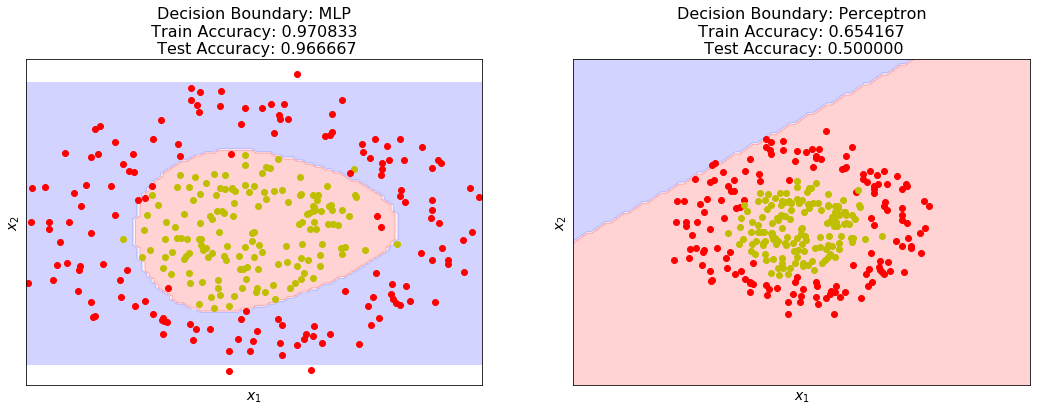

In [18]:
plt.figure(figsize=(18,6))

plt.subplot(121)
decision_boundary_class_colored(mlp_clf, X, plotDistanceFromHyperplane=False)
plt.plot(X_train[y_train.ravel()==0, 0], X_train[y_train.ravel()==0, 1], "ro")
plt.plot(X_train[y_train.ravel()==1, 0], X_train[y_train.ravel()==1, 1], "yo")
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "ro")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: MLP\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_mlp, test_accuracy_mlp) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_class_colored(perceptron_clf, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: Perceptron\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_perceptron, test_accuracy_perceptron) , fontsize=16)
plt.xticks(())
plt.yticks(())

plt.show()